<h1 style="color:rgb(0,120,170)">Artificial Intelligence in Life Sciences</h1>
<h2 style="color:rgb(0,120,170)">Molecule generation</h2>

<b>Authors:</b> Luukkonen<br>
<b>Date:</b> 19-03-2024

This file is part of the "Artificial Intelligence in Life Sciences" lecture material.
The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational
use only. Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed
or in electronic form, requires explicit prior acceptance of the authors.

In [1]:
# Standard library
import warnings
from multiprocessing import Pool

# Ignore warnings
warnings.filterwarnings("ignore")

# Third-party
import fcd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, QED
from rdkit.Chem.MolStandardize import rdMolStandardize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Local application imports
from resources.utils import get_Pareto_fronts

# RDKit logging
RDLogger.DisableLog('rdApp.*')

# Reproducibility
np.random.seed(1234)
torch.manual_seed(1234)

print("RDKit:", rdkit.__version__)

RDKit: 2023.09.5


Some helper functions:

In [34]:
def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi, sanitize=True)
        can_smi = Chem.MolToSmiles(mol)
    except:
        can_smi = None
    return can_smi

def validate_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return False if mol is None else True

def draw_mols(mols, ncols=5):
    """Draws a list of molecules on a grid"""
    nrows = int(np.ceil(len(mols) / ncols))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2, nrows*2))
    for i, mol in enumerate(mols):
        ax = axs[i // ncols, i % ncols]
        img = Chem.Draw.MolToImage(mol)
        ax.imshow(img)
        ax.axis('off')
    plt.show()
    
def get_Pareto_fronts(scores):
    """Identify the Pareto fronts from a given set of scores.
    
    Parameters
    ----------
    scores : numpy.ndarray
        An (n_points, n_scores) array of scores.
            
    Returns
    -------
    list of numpy.ndarray
        A list containing the indices of points belonging to each Pareto front.
    """
    
    # Initialize
    population_size = scores.shape[0]
    population_ids = np.arange(population_size)
    all_fronts = []

    # Identify Pareto fronts
    while population_size > 0:
        # Identify the current Pareto front
        pareto_front = np.ones(population_size, dtype=bool)
        for i in range(population_size):
            for j in range(population_size):
                # Strictly j better than i in all scores (i dominated by j) 
                # -> i not in Pareto front
                if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                    pareto_front[i] = 0
                    break

        # Add the current Pareto front to the list of all fronts
        current_front_ids = population_ids[pareto_front]
        all_fronts.append(current_front_ids)

        # Remove the current Pareto front from consideration in future iterations
        scores = scores[~pareto_front]
        population_ids = population_ids[~pareto_front]
        population_size = scores.shape[0]

    return all_fronts

<h2 style="color:rgb(0,120,170)">Distribution learning</h2>

Molecular generators are deep generative models (RNNs, Transformers, VAEs, GANs,...) that learn from a corpus of chemical structures—whether encoded as SMILES, SELFIES, molecular graphs, or other formats—to propose novel compounds. In distribution learning, we train these generators not just to recreate individual molecules but to match the overall property distribution of the training set (e.g., log P, molecular weight, topological features), ensuring that samples drawn from the model exhibit the same physicochemical profile as the originals. By capturing this underlying chemical space, distribution-learned generators can explore new molecules while maintaining characteristics of training set molecules (e.g., general druglikeness of molecules.)

Here, we train a compact autoregressive RNN on SMILES representations. Our training set consists of 130,000 molecules drawn from a simplified version of the [QM9 dataset](http://quantum-machine.org/datasets/), which comprises small organic molecules made of only C,N,O,F and H with up to nine heavy atoms computed quantum chemical properties.

Number of SMILES:  128880


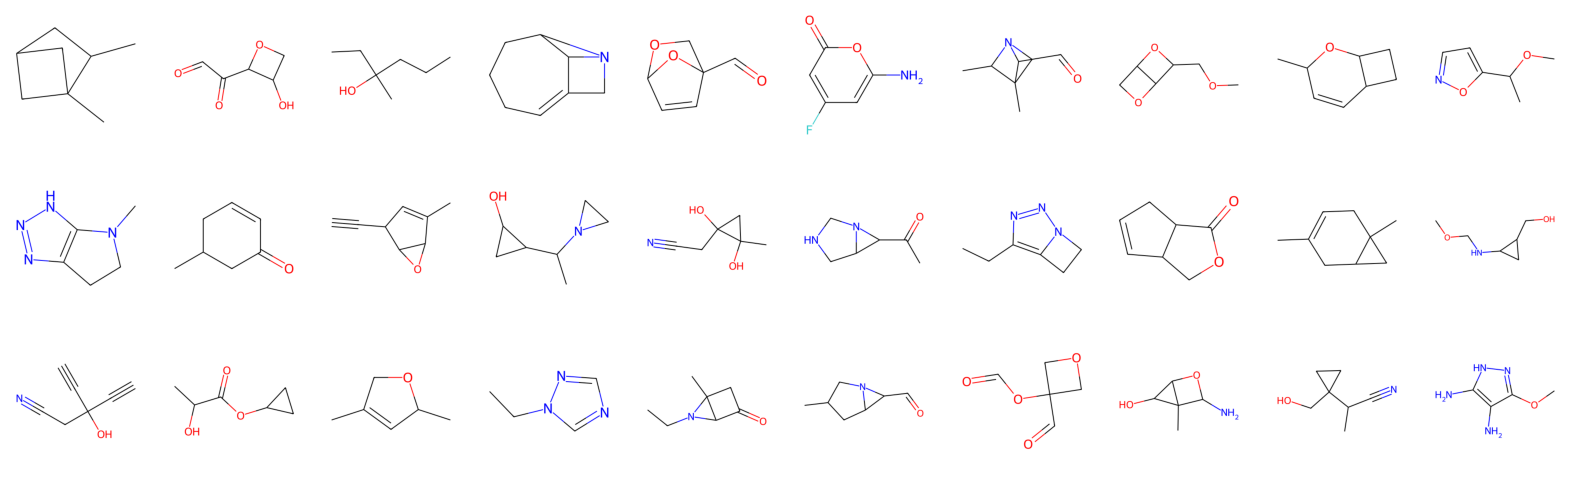

In [3]:
# Load the QM9 SMILES
smiles_list = pd.read_csv("resources/QM9_smiles_simplified.txt", header=None)[0].tolist()
print("Number of SMILES: ", len(smiles_list))

draw_mols([Chem.MolFromSmiles(smi) for smi in smiles_list[:30]], ncols=10)

To train an autoregressive model, we first need to tokenize our SMILES strings. This class builds a vocabulary that maps tokens to indices and vice versa. 

Here, we use a simple character-based tokenization strategy. While sufficient for our simple molecules, it can be suboptimal for more complex ones — for instance, the chlorine atom will be split into two tokens: `C` and `l`. For larger or more diverse datasets, more sophisticated tokenization approaches (e.g., by atom type or substructures) are recommended. *Hint: Several SMILES tokenizers are available online.*

In [4]:
# Create vocabulary
class Vocabulary:
    def __init__(self, smiles_list, start_token='$', end_token='^', pad_token='&'):
        self.smiles_list = smiles_list
        # Add special tokens: start, end, padding
        self.vocab = set([start_token, end_token, pad_token])
        for s in smiles_list:
            self.vocab.update(list(s))
        self.vocab = sorted(list(self.vocab))
        self.vocab_size = len(self.vocab)
        self.char_to_idx = {c: i for i, c in enumerate(self.vocab)}
        self.idx_to_char = {i: c for i, c in enumerate(self.vocab)}
        
    def encode(self, s):
        return [self.char_to_idx[c] for c in s]
    
    def decode(self, l):
        return ''.join([self.idx_to_char[i] for i in l])
    
vocab = Vocabulary(smiles_list)
print("Vocabulary size: ", vocab.vocab_size)
print("Vocabulary: ", vocab.vocab)

Vocabulary size:  23
Vocabulary:  ['#', '$', '&', '(', ')', '1', '2', '3', '4', '5', '6', '=', 'C', 'F', 'H', 'N', 'O', '[', ']', '^', 'c', 'n', 'o']


We convert the tokenized SMILES into sequences of integer indices using the vocabulary. Start (`$`) and end (`^`) tokens are added to each sequence to help the model learn when to begin and stop generating. We also, pad (`&`) the sequences to `max_len` to be able process them in batches.

In [5]:
# Encode the SMILES with the vocabulary (add start and end tokens, and padding)
def encode_smiles(smiles, vocab, max_len, start_token='$', end_token='^', padding_token='&'):
    # Preprocess SMILES
    processed_smiles = start_token + smiles + end_token + padding_token * (max_len - len(smiles))
    # Encode SMILES
    encoded_smiles = np.array([vocab.char_to_idx[c] for c in processed_smiles])
    return encoded_smiles

max_len = max([len(s) for s in smiles_list])
print("Max length of SMILES: ", max_len)
encoded_smiles = np.array([encode_smiles(s, vocab, max_len) for s in smiles_list])
print("Encoded SMILES shape: ", encoded_smiles.shape)
print(smiles_list[0], encoded_smiles[0])

Max length of SMILES:  27
Encoded SMILES shape:  (128880, 29)
CC1CC2CC1(C)C2 [ 1 12 12  5 12 12  6 12 12  5  3 12  4 12  6 19  2  2  2  2  2  2  2  2
  2  2  2  2  2]


We define a custom PyTorch Dataset to feed the model input–target pairs for autoregressive training. The inputs are the SMILES sequences excluding the last token, while the targets are the same sequences shifted one position to the left. This setup allows the model to learn to predict the next token at each position.

In [6]:
# Create dataset and dataloader
class SMILESDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

inputs = encoded_smiles[:, :-1]
targets = encoded_smiles[:, 1:]
dataset = SMILESDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

We use a simple RNN-based neural network to model the distribution over SMILES sequences. Given a sequence of tokens, the model learns to predict the next token at each position.

In [7]:
# RNN next token prediction model
class RNN(nn.Module):
    def __init__(self, vocab, embedding_dim, hidden_dim, device='cpu'):
        super().__init__()
        self.vocab = vocab
        self.embedding = nn.Embedding(self.vocab.vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, self.vocab.vocab_size)

    def forward(self, x, hidden=None):
        emb = self.embedding(x)                
        out, hidden = self.rnn(emb, hidden)    
        logits = self.fc(out)                  
        return logits, hidden
    
    def generate(self, max_len=100, temperature=1.0, canonicalize=False, start_token='$', end_token='^',):

        start_idx = self.vocab.char_to_idx[start_token]
        end_idx   = self.vocab.char_to_idx[end_token]

        hidden = None
        input_idx = torch.tensor([[start_idx]])
        generated = [start_idx]

        for _ in range(max_len):
            logits, hidden = self.forward(input_idx, hidden)
            # take only the last timestep
            last_logits = logits[:, -1, :] / temperature
            probs       = F.softmax(last_logits, dim=-1)
            next_idx    = torch.multinomial(probs, num_samples=1)  # shape (batch=1,1)
            token_id    = next_idx.item()
            generated.append(token_id)
            if token_id == end_idx:
                break
            # feed this token in next iteration
            input_idx = next_idx

        # decode: drop start and end
        chars = [self.vocab.idx_to_char[i] for i in generated[1:-1]]
        smiles = ''.join(chars)
        return canonicalize_smiles(smiles) if canonicalize else smiles
    
    def sample(self, n_samples=10, max_len=100, temperature=1.0, canonicalize=False, start_token='$', end_token='^'):
        # Sample n_samples SMILES from the model
        samples = []
        for _ in range(n_samples):
            smiles = self.generate(max_len=max_len, temperature=temperature, canonicalize=canonicalize, start_token=start_token, end_token=end_token)
            if smiles is not None:
                samples.append(smiles)
        return samples    

Now, let's initialize our model and train it for 5 epochs:

In [8]:
# Hyperparameters
embedding_dim = 64
hidden_dim    = 128
num_epochs    = 5
learning_rate = 1e-3
log_interval  = 100   # how many batches between sample generations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss, optimizer
model     = RNN(vocab, embedding_dim, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.char_to_idx['&']) # ignore padding in loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

vocab_size = vocab.vocab_size  # for flattening logits

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss  = 0.0
    valid_count = 0

    for step, (inputs, targets) in enumerate(dataloader, start=1):
        # Move to device and ensure LongTensors
        inputs  = inputs.long().to(device)
        targets = targets.long().to(device)

        optimizer.zero_grad()
        logits, _ = model(inputs)  
        logits_flat  = logits.view(-1, vocab_size)
        targets_flat = targets.view(-1)

        loss = criterion(logits_flat, targets_flat)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

        # Every log_interval steps, sample a SMILES and report
        if step % log_interval == 0:
            model.eval()
            with torch.no_grad():
                sample    = model.generate(max_len= max_len, temperature=1.0, canonicalize=False)
                is_valid  = validate_smiles(sample)
            model.train()

            print(
                f"Epoch {epoch}/{num_epochs} "
                f"Step {step}/{len(dataloader)} "
                f"Batch Loss: {loss.item():.4f} "
                f"Sample: {sample:<{max_len}} "
                f"Valid: {is_valid}"
            )
            if is_valid:
                valid_count += 1

    # End of epoch logging
    avg_loss = epoch_loss / len(dataloader)
    print(
        f"==== Epoch {epoch} Complete ====\n"
        f"Avg Loss: {avg_loss:.4f} | "
        f"Valid Samples in logs: {valid_count}/{len(dataloader)//log_interval}\n"
    )

    # Save a checkpoint
    torch.save(model.state_dict(), f"rnn_model_epoch{epoch}.pth")


Epoch 1/5 Step 100/1007 Batch Loss: 1.4216 Sample: CC1C(CN1                    Valid: False
Epoch 1/5 Step 200/1007 Batch Loss: 1.2084 Sample: CC1C(O)CO=CNC1              Valid: False
Epoch 1/5 Step 300/1007 Batch Loss: 1.1259 Sample: CN1C2(COC1C2)N31            Valid: False
Epoch 1/5 Step 400/1007 Batch Loss: 1.0984 Sample: C#CC1C(C)C12O               Valid: False
Epoch 1/5 Step 500/1007 Batch Loss: 1.1042 Sample: C#Cc1onc2c1nnn              Valid: False
Epoch 1/5 Step 600/1007 Batch Loss: 1.0775 Sample: O=c1cnnc(N)n1               Valid: False
Epoch 1/5 Step 700/1007 Batch Loss: 1.0055 Sample: O=C#CC1Cn=C(N)[nH]1)[       Valid: False
Epoch 1/5 Step 800/1007 Batch Loss: 1.0474 Sample: CC1(C)C2CC(=O)N3C1          Valid: False
Epoch 1/5 Step 900/1007 Batch Loss: 1.0214 Sample: COC1CCC1O                   Valid: True
Epoch 1/5 Step 1000/1007 Batch Loss: 1.0060 Sample: CC12CC1C3CC24O              Valid: False
==== Epoch 1 Complete ====
Avg Loss: 1.1675 | Valid Samples in logs: 1/10

Epoch

We use the trained model to generate new SMILES:

In [9]:
model.load_state_dict(torch.load("rnn_model_epoch5.pth"))
model.eval()

n_samples = 10_000
generated_smiles = model.sample(n_samples=10_000, max_len=max_len, temperature=1.0, canonicalize=True)
valid_smiles = [smi for smi in generated_smiles if smi is not None]

At a visual inspections, the generated molecules look similar to our training data. But there are also some funcky ones:

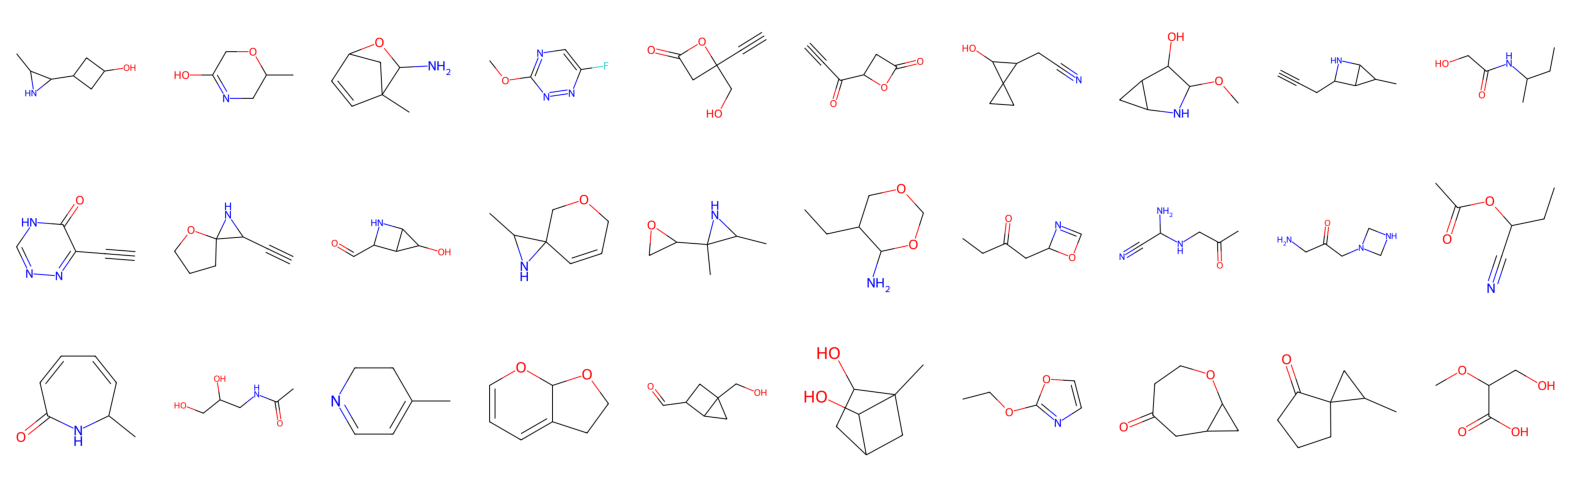

In [10]:
draw_mols([Chem.MolFromSmiles(smi) for smi in valid_smiles[:30] if smi is not None], ncols=10)

<h2 style="color:rgb(0,120,170)">Evaluation of the generated molecules</h2>

<h3 style="color:rgb(0,120,170)">Validity, Uniqueness and Novelty</h3>

- **Validity**: fraction of syntactically valid SMILES (aka molecules that can be parsed by rdkit)
- **Uniqueness**: fraction of unique molecules generated by the model. If the model "collapses" and just generates the same valid molecule over and over we would see that in this metric.
- **Novelty**: fraction of molecules that do not exist in the training data. Does the models generate new/novel compounds or just copy molecules from the training data.

In [ ]:
# Validity
validity = len(valid_smiles) / n_samples
print("Validity: ", validity)

# Uniqueness
unique_smiles = list(set(valid_smiles))
uniqueness = len(unique_smiles) / n_samples
print("Uniqueness: ", uniqueness)

# Novelty
novel_smiles = list(set(unique_smiles) - set(smiles_list))
novelty = len(novel_smiles) / n_samples
print("Novelty: ", novelty)

Validity:  0.8099
Uniqueness:  0.7903
Novelty:  0.3433


<h3 style="color:rgb(0,120,170)">Fréchet ChemNet Distance (FCD)</h3>

In the case of distribution learning, the key metric is the [Fréchet ChemNet Distance (FCD)](https://github.com/bioinf-jku/FCD) which calculates the distance between the distribution of reference real-world molecules and the distribution of molecules from a generative model. The more similar the distributions the lower the FCD. 

<div align="center">
  <img src="resources/fcd.gif" alt="FCD" />
</div>

Before we can compare distributions of molecules, in a first step we load the reference model included in the FCD package. This model has been trained on a large set of molecules.

In [12]:
# Load ChemNet model
chemnet_model = fcd.load_ref_model()

To calculate the FCD we need some statistics, namely the mean and covariance of the activations from the reference model we loaded earlier. The FCD then compares these statistics for the two sets.

Important considerations when preparing data: 
- Canonicalization matters — always use RDKit canonicalization for consistency.
- Carefully choose which subset of generated molecules to evaluate.
- Ensure consistent sample sizes across real and generated sets, as FCD is sensitive to the number of molecules.

In [13]:
# Randomly sample reference SMILES (to speed up the process and have a similar number of samples as generated)
reference_smiles = np.random.choice(smiles_list, len(valid_smiles), replace=False,) 

In [14]:
# Get FCD with valid generated SMILES --> This one is used in the challenge
fcd_value_valid = fcd.get_fcd(reference_smiles, valid_smiles, model=chemnet_model)
print("FCD (w/ all valid SMILES): ", fcd_value_valid)

FCD (w/ all valid SMILES):  0.32449024927148074


In [15]:
# Get FCD with unique generated SMILES
fcd_value_unique = fcd.get_fcd(reference_smiles, unique_smiles, model=chemnet_model)
print("FCD (w/ only unique SMILES): ", fcd_value_unique)

FCD (w/ only unique SMILES):  0.32019729221825344


In [16]:
# Get FCD with novel generated SMILES
fcd_value_novel = fcd.get_fcd(reference_smiles, novel_smiles, model=chemnet_model)
print("FCD (w/ only novel SMILES): ", fcd_value_novel)

FCD (w/ only novel SMILES):  1.2319583799545875


To show that canonicalization is important, let's see what happens if we don't use canonical SMILES:

In [17]:
uncanonicalized_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), doRandom=True) for smi in valid_smiles]
fcd_value = fcd.get_fcd(reference_smiles, uncanonicalized_smiles, model=chemnet_model)
print('FCD (w/ non canonical smiles): ', fcd_value)

FCD (w/ non canonical smiles):  0.7028960448281154


<h3 style="color:rgb(0,120,170)">Physicochemical properties</h3>

Typically, we would like the molecules to have some good physicochemical properties. For example, in drug discovery we are would like to have a molecules with a high QED value (>0.75) and intermediate logP value (~0-3). Let's see the property distributions of our generated molecules:

In [ ]:
def qed_scorer(smiles):
    return QED.qed(Chem.MolFromSmiles(smiles))

def logP_scorer(smiles):
    return Descriptors.MolLogP(Chem.MolFromSmiles(smiles))

df = pd.DataFrame({'SMILES' : unique_smiles})
df['QED'] = df.SMILES.apply(lambda x: qed_scorer(x))
df['logP'] = df.SMILES.apply(lambda x: logP_scorer(x))

Fraction of desired molecules:  0.0


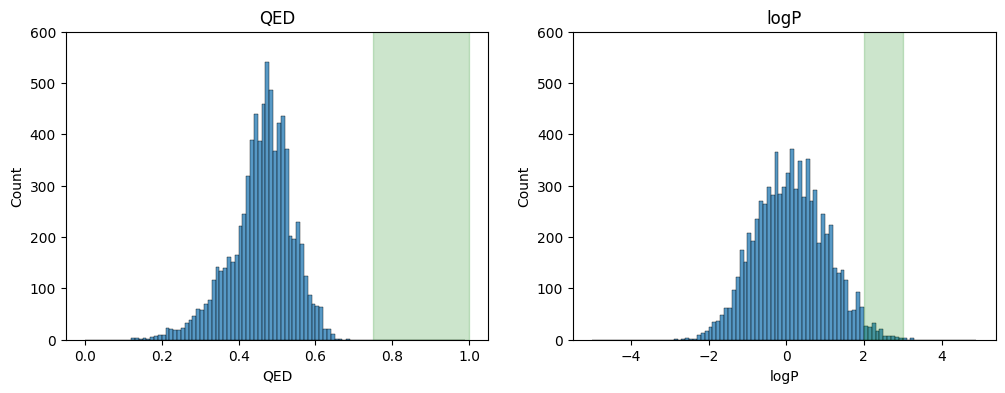

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df['QED'], bins=np.arange(0,1,0.01), ax=ax[0])
sns.histplot(df['logP'], bins=np.arange(-5,5,0.1), ax=ax[1])
ax[0].set_title('QED')
ax[1].set_title('logP')

ax[0].fill_between([0.75, 1], 0, 1000, color='green', alpha=0.2)
ax[1].fill_between([2, 3], 0, 1000, color='green', alpha=0.2)
ax[0].set_ylim(0, 600)
ax[1].set_ylim(0, 600)

print("Fraction of desired molecules: ", len(df[(df['QED'] > 0.75) & (df['logP'].between(2,3))]) / n_samples)

Not very good, but it is normal that both QED and logP values are not very druglike as the our training data was not druglike molecules... but maybe we can make the druglike.

<h2 style="color:rgb(0,120,170)">Goal-direct learning</h2>

Let's now optimize our molecular generator to produce more drug-like molecules — for example, those with QED > 0.75 and logP in the range of 2–3.

Goal-directed generation requires a scoring function to evaluate molecule quality. When optimizing for multiple properties (e.g., QED and logP), we alse need a multi-objective optimization strategy to balance the different goals.

<h3 style="color:rgb(0,120,170)">Scorer modifiers</h3>

Raw scorers from the different scorers are typically transformed with a modifier. Modifier functions are used to:

- Convert all objectives into maximization (or minimization) tasks
- Scale scores to a common range (typically 0–1) for aggregation
- Reduce sensitivity to unimportant score extremes

They help ensure fair and stable multi-objective optimization.

In [30]:
def sigmoid(x, k=1, x0=0):
    x = np.array(x)
    return 1 / (1 + np.exp(-k*(x-x0)))

# QED modifier
def qed_modifier(x):
    return sigmoid(x, 20, 0.5)

# logP modifier
def logP_modifier(x):
    return sigmoid(x, 3, 0.5) + sigmoid(x, -3, 4.5) -1

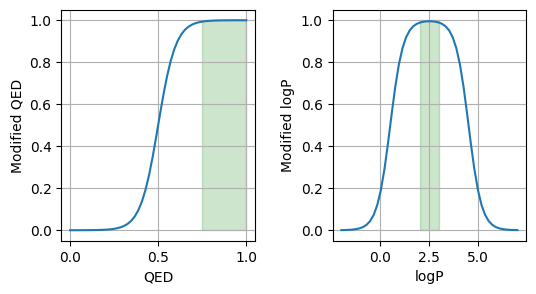

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(6,3), gridspec_kw={'wspace': 0.4})

# QED modifier
x = np.linspace(0,1)
y = qed_modifier(x)
ax[0].plot(x,y)
ax[0].set_xlabel('QED')
ax[0].set_ylabel('Modified QED')
ax[0].grid()

# logP modifier
x = np.linspace(-2,7)
y = logP_modifier(x)
ax[1].plot(x,y)
ax[1].set_xlabel('logP')
ax[1].set_ylabel('Modified logP')
ax[1].grid()

ax[0].fill_between([0.75, 1], 0, 1, color='green', alpha=0.2)
ax[1].fill_between([2, 3], 0, 1, color='green', alpha=0.2)


<h3 style="color:rgb(0,120,170)">Multi-objective optimization</h3>

There are several approaches to transform multiple scores into a singe one:
- raking of molecules based on [Pareto dominance](https://en.wikipedia.org/wiki/Pareto_front)
- [weight/aggregation functions](https://en.wikipedia.org/wiki/Weight_function): weighted sum, weighted mean, ...

Let's see the ranking of our previous generated molecules with three strategies: arithmetic and geometric mean (weighted sum and product with the same weight for all objectives) and Pareto ranking:

In [35]:
# Compute modified score
df['QED_mod'] = df.QED.apply(lambda x : qed_modifier(x))
df['logP_mod'] = df.logP.apply(lambda x : logP_modifier(x))

# Arithmetic mean
df['score_WS'] = df[['QED_mod', 'logP_mod']].mean(axis=1)

# Geometric mean
df['score_WP'] = np.sqrt(df['QED_mod'] * df['logP_mod'])

# Pareto ranking
df['score_PR'] = 0
fronts = get_Pareto_fronts(df[['QED_mod', 'logP_mod']].values)
for i, idx in enumerate(fronts):
    df.loc[idx, 'score_PR'] = 1 - i / len(fronts)

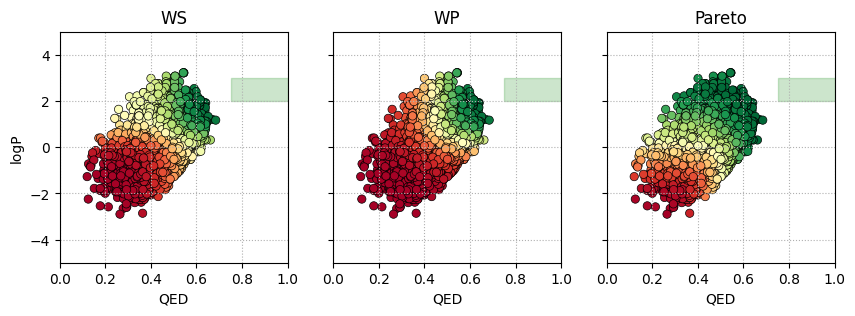

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True)
sns.scatterplot(data=df, x='QED', y='logP', hue='score_WS', ax=ax[0], palette='RdYlGn', ec='k', legend=False)
sns.scatterplot(data=df, x='QED', y='logP', hue='score_WP', ax=ax[1], palette='RdYlGn', ec='k', legend=False)
sns.scatterplot(data=df, x='QED', y='logP', hue='score_PR', ax=ax[2], palette='RdYlGn', ec='k', legend=False)

ax[0].set_title('WS')
ax[1].set_title('WP')
ax[2].set_title('Pareto')

for a in ax:
    a.set_xlim(0,1)
    a.set_ylim(-5,5)
    a.fill_between([0.75,1], 2, 3, color='green', alpha=0.2)
    a.grid(linestyle=':')

<h3 style="color:rgb(0,120,170)">Iterative distributed learning</h3>

Let's see if we can guide the generator to design desired molecules with an iterative distribution learning process:
1. We generate `batch_size` molecules and score the with a `scorer`
2. Pick `top_k` molecules based on scores
3. Finetune model for one epoch with the selected molecules
4. Go to 1.

We start by defining our scorer that combines the modified QED and logP scores for each molecule with a geometric mean:

In [39]:
def scorer(smiles: str) -> float:
    
    if smiles is None:
        return -1.0
    mol = Chem.MolFromSmiles(smiles)
    qed_score = qed_modifier(Descriptors.qed(mol))
    logp_score = logP_modifier(Descriptors.MolLogP(mol))
    
    return np.sqrt(qed_score * logp_score) 
    

And a helper function to perform iterative finetuning:

In [ ]:
def fine_tune_by_topk(
    model: RNN,
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    max_len: int,
    scoring_fn,
    n_samples: int = 1000,
    top_k: int = 100,
    temperature: float = 1.0,
    device: torch.device = None
):
    """
    1) Sample n_samples molecules
    2) Score them with scoring_fn(smiles)->float
    3) Pick the top_k sequences by reward
    4) Build input/target pairs from those top_k sequences
    5) Compute standard cross‐entropy loss (teacher forcing) and update
    """
    if device is None:
        device = next(model.parameters()).device

    # 1) Sampling
    model.eval()
    seqs = []
    rewards = []
    while len(seqs) < n_samples:
        # Generate a SMILES
        smi = model.generate(max_len=max_len, temperature=temperature, canonicalize=True)
        if smi is None: # Skip invalid SMILES
            continue
        if smi in seqs: # Avoid duplicates
            continue
        if any([c not in model.vocab.vocab for c in smi]): # Avoid sequences with unknown characters
            continue
        r = scoring_fn(smi)
        seqs.append(smi)
        rewards.append(r)

    # 2) Select top_k by reward
    idxs = sorted(range(len(seqs)), key=lambda i: rewards[i], reverse=True)[:top_k]
    top_seqs = [seqs[i] for i in idxs]
    top_rewards = [rewards[i] for i in idxs]
    
    # 3) Create input/target pairs for top_k sequences
    encoded_seqs = np.array([encode_smiles(s, model.vocab, max_len) for s in top_seqs])
    inputs = torch.tensor(encoded_seqs[:, :-1], dtype=torch.long, device=device)  # (top_k, seq_len-1)
    targets = torch.tensor(encoded_seqs[:, 1:], dtype=torch.long, device=device) # (top_k, seq_len-1)

    # 4) Train on top_k sequences
    model.train()
    optimizer.zero_grad()
    logits, _ = model(inputs)  # (top_k, seq_len-1, vocab_size)
    loss = loss_fn(logits.view(-1, model.vocab.vocab_size), targets.view(-1))
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    # 5) Return statistics
    return {
        "loss": loss.item(),
        "avg_reward": sum(rewards) / len(rewards),
        "avg_topk_reward": sum(top_rewards) / top_k,
    }


In [41]:
# Load model
model = RNN(vocab, embedding_dim, hidden_dim).to(device)
model.load_state_dict(torch.load("rnn_model_epoch5.pth"))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

top_k = 16
batch_size = top_k * 4
n_iters = 100
best_reward = -1.0

for step in range(n_iters):
    stats = fine_tune_by_topk(
        model,
        optimizer,
        nn.CrossEntropyLoss(ignore_index=model.vocab.char_to_idx['&']),
        n_samples=batch_size,
        max_len=100,
        scoring_fn=scorer,
        top_k=top_k,
        temperature=1.0,
    )
    
    # Save model and print stats if average reward improved
    if stats['avg_reward'] > best_reward:
        best_reward = stats['avg_reward']
        torch.save(model.state_dict(), f"rnn_model_finetuned.pth")  
        print(
            f"Step {step}: loss={stats['loss']:.4f}, "
            f"avg_reward={stats['avg_reward']:.4f}, "
            f"topk_mean={stats['avg_topk_reward']:.4f}")
        count = 0
    else:
        count += 1
        if count > 10:
            model.load_state_dict(torch.load("rnn_model_finetuned.pth"))  
            count = 0


Step 0: loss=0.8629, avg_reward=0.3102, topk_mean=0.6802
Step 1: loss=0.8397, avg_reward=0.4074, topk_mean=0.7628
Step 2: loss=0.8033, avg_reward=0.5270, topk_mean=0.8389
Step 3: loss=0.7381, avg_reward=0.6592, topk_mean=0.8696
Step 4: loss=0.8185, avg_reward=0.6675, topk_mean=0.9012
Step 5: loss=0.7942, avg_reward=0.6884, topk_mean=0.8874
Step 7: loss=0.8165, avg_reward=0.7685, topk_mean=0.9473
Step 11: loss=0.8036, avg_reward=0.7775, topk_mean=0.9717
Step 12: loss=0.8208, avg_reward=0.7939, topk_mean=0.9799
Step 21: loss=0.9897, avg_reward=0.8147, topk_mean=0.9881
Step 28: loss=0.9212, avg_reward=0.8361, topk_mean=0.9911
Step 35: loss=0.7209, avg_reward=0.8403, topk_mean=0.9887
Step 36: loss=0.7240, avg_reward=0.8412, topk_mean=0.9861
Step 39: loss=0.6444, avg_reward=0.8832, topk_mean=0.9924
Step 44: loss=0.5797, avg_reward=0.9091, topk_mean=0.9949
Step 45: loss=0.5468, avg_reward=0.9456, topk_mean=0.9928
Step 56: loss=0.5055, avg_reward=0.9649, topk_mean=0.9953
Step 60: loss=0.4684,

Now let's regenerate some new molecules with our finetuned model:

In [42]:
n_samples = 10_000
model.load_state_dict(torch.load("rnn_model_finetuned.pth"))
generated_guided_smiles = model.sample(n_samples=n_samples, max_len=max_len, temperature=1.0, canonicalize=True)
valid_guided_smiles = [smi for smi in generated_guided_smiles if smi is not None]
unique_guided_smiles = list(set(valid_guided_smiles))
novel_guided_smiles = list(set(unique_guided_smiles) - set(smiles_list))

print("Fraction of valid SMILES: ", len(valid_guided_smiles) / n_samples)
print("Fraction of unique SMILES: ", len(unique_guided_smiles) / n_samples)
print("Fraction of novel SMILES: ", len(novel_guided_smiles) / n_samples)

Fraction of valid SMILES:  0.9314
Fraction of unique SMILES:  0.5613
Fraction of novel SMILES:  0.5613


With a visual inspection we can see that our molecules have changed quite a lot:

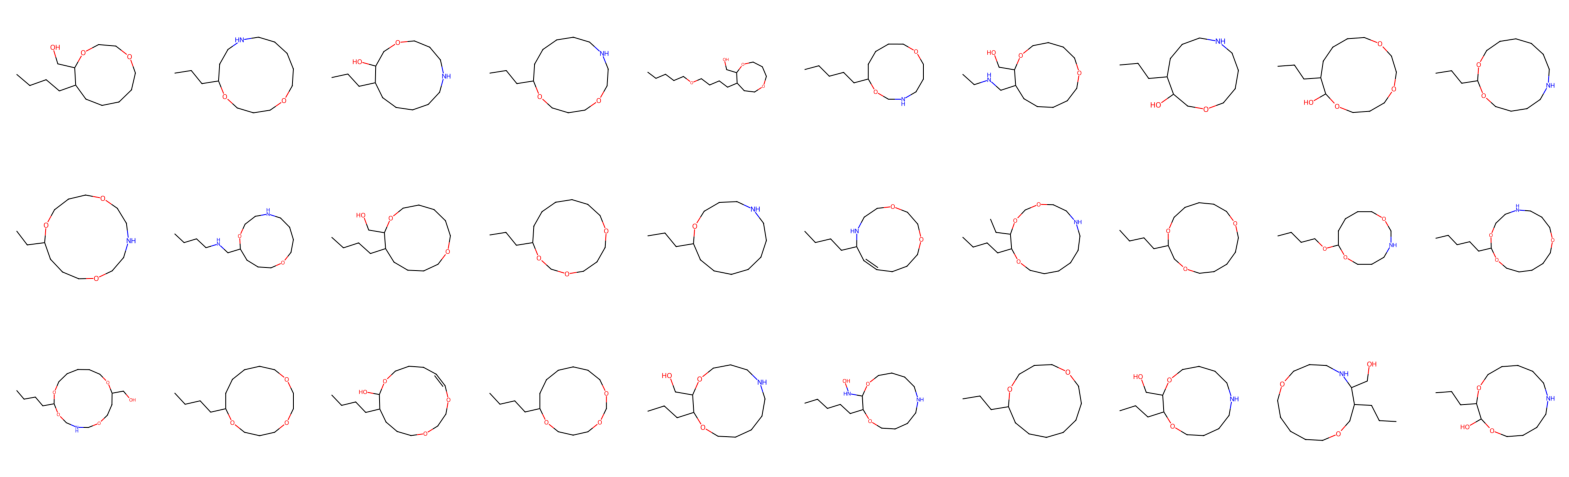

In [45]:
draw_mols([Chem.MolFromSmiles(smi) for smi in valid_guided_smiles[:30]], ncols=10)

What about the properties of interest:

In [ ]:
df_guided = pd.DataFrame({'SMILES' : unique_guided_smiles})
df_guided['QED'] = df_guided.SMILES.apply(lambda x: qed_scorer(x))
df_guided['logP'] = df_guided.SMILES.apply(lambda x: logP_scorer(x))
df_guided['QED_mod'] = df_guided.QED.apply(lambda x : qed_modifier(x))
df_guided['logP_mod'] = df_guided.logP.apply(lambda x : logP_modifier(x))
df_guided['score_WP'] = np.sqrt(df_guided['QED_mod'] * df_guided['logP_mod'])

Fraction of desired molecules:  0.203


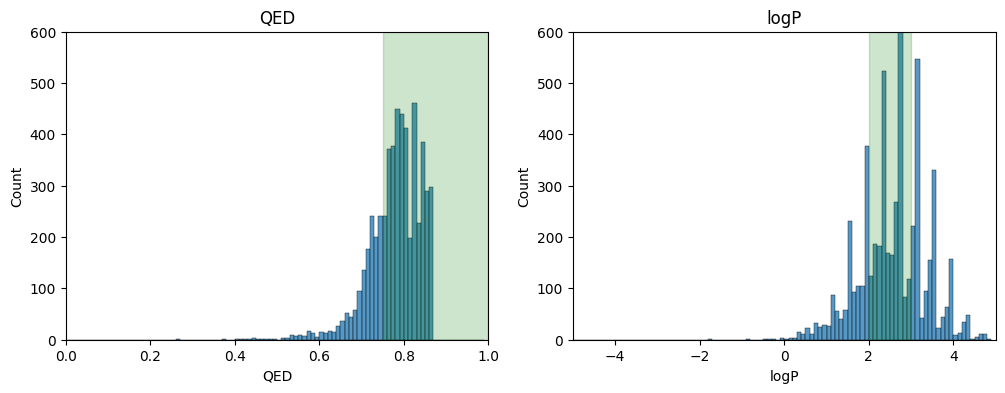

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_guided['QED'], bins=np.arange(0,1,0.01), ax=ax[0])
sns.histplot(df_guided['logP'], bins=np.arange(-5,5,0.1), ax=ax[1])
ax[0].set_title('QED')
ax[1].set_title('logP')
ax[0].set_xlim(0,1)
ax[1].set_xlim(-5,5)

ax[0].fill_between([0.75, 1], 0, 1000, color='green', alpha=0.2)
ax[1].fill_between([2, 3], 0, 1000, color='green', alpha=0.2)
ax[0].set_ylim(0, 600)
ax[1].set_ylim(0, 600)

print("Fraction of desired molecules: ", len(df_guided[(df_guided['QED'] > 0.75) & (df_guided['logP'].between(2,3))]) / n_samples)

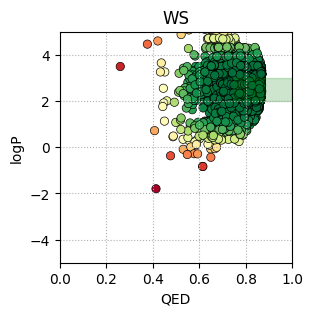

In [49]:
fig, ax = plt.subplots(1,1, figsize=(3,3), sharex=True, sharey=True)
sns.scatterplot(data=df_guided, x='QED', y='logP', hue='score_WP', ax=ax, palette='RdYlGn', ec='k', legend=False)
ax.set_title('WS')

ax.set_xlim(0,1)
ax.set_ylim(-5,5)
ax.fill_between([0.75,1], 2, 3, color='green', alpha=0.2)
ax.grid(linestyle=':')